Cell 1 — Install dependencies

In [ ]:
!pip -q install "openai>=1.0.0" openml pandas numpy scikit-learn matplotlib


Cell 2 — Imports + reproducibility

In [ ]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


Cell 3 — (Optional) OpenAI key setup

Recommended (Colab Secrets):
Colab → left sidebar → Secrets → add OPENAI_API_KEY

In [ ]:
# If using Colab Secrets, OPENAI_API_KEY is usually available automatically.
# Otherwise you can set it manually (not recommended to hardcode in shared notebooks):
os.environ["OPENAI_API_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx" #paste your API key here

api_key = os.environ.get("OPENAI_API_KEY")
print("OPENAI_API_KEY present:", bool(api_key))


OPENAI_API_KEY present: True


Cell 4 — OpenAI client + helper (Responses API)
Cell 5 — Define actions, objectives, normalization, scoring

In [ ]:
from openai import OpenAI

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def llm_explain_ranking(payload: dict, model: str = "gpt-5.2") -> str:
    """
    Calls OpenAI Responses API to generate an explanation.
    If key is missing, returns a placeholder explanation.
    """
    if not os.environ.get("OPENAI_API_KEY"):
        return "LLM disabled (no OPENAI_API_KEY). Explanation placeholder."

    prompt = f"""
You are assisting a manufacturing operations decision-maker.

Task:
Given a multi-criteria evaluation of recovery actions, produce a concise explanation:
1) State the recommended action and why (tie to objective weights).
2) Compare the top 2 actions and mention the key trade-off.
3) Mention any safety caveat if safety risk is not minimal.

Return 6–10 sentences. Be precise and avoid fluff.

DATA (JSON):
{json.dumps(payload, indent=2)}
"""

    resp = client.responses.create(
        model=model,
        input=prompt
    )
    # The SDK provides output text in different ways depending on version;
    # this is the most common pattern:
    return resp.output_text


Part A — Core decision model (Section 4 in code)
Cell 5 — Define actions, objectives, normalization, scoring

In [ ]:
ACTIONS = ["bypass", "degraded_mode", "repair_now", "reschedule"]
OBJECTIVES = ["delay", "energy", "quality", "safety"]  # all minimized

def minmax_normalize(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        mn, mx = out[c].min(), out[c].max()
        if mx == mn:
            out[c] = 0.0
        else:
            out[c] = (out[c] - mn) / (mx - mn)
    return out

def weighted_score(df_norm: pd.DataFrame, weights: Dict[str, float]) -> pd.Series:
    w = np.array([weights[o] for o in OBJECTIVES], dtype=float)
    X = df_norm[OBJECTIVES].values
    return (X * w).sum(axis=1)

def rank_actions(action_impacts: pd.DataFrame, weights: Dict[str, float]) -> pd.DataFrame:
    """
    action_impacts: rows=actions, cols=OBJECTIVES (raw scores, lower is better)
    returns: dataframe with normalized scores + composite + rank
    """
    df = action_impacts.copy()
    df["action"] = df.index
    df_norm = minmax_normalize(df, OBJECTIVES)
    df_norm["composite"] = weighted_score(df_norm, weights)
    df_norm = df_norm.sort_values("composite", ascending=True).reset_index(drop=True)
    df_norm["rank"] = np.arange(1, len(df_norm) + 1)
    return df_norm[["rank", "action"] + OBJECTIVES + ["composite"]]


Cell 6 — Define weight profiles (human priorities)

In [ ]:
WEIGHT_PROFILES = {
    "balanced":      {"delay": 0.30, "energy": 0.20, "quality": 0.25, "safety": 0.25},
    "safety_first":  {"delay": 0.15, "energy": 0.10, "quality": 0.20, "safety": 0.55},
    "energy_first":  {"delay": 0.20, "energy": 0.45, "quality": 0.20, "safety": 0.15},
    "throughput":    {"delay": 0.55, "energy": 0.10, "quality": 0.20, "safety": 0.15},
    "quality_first": {"delay": 0.15, "energy": 0.10, "quality": 0.60, "safety": 0.15},
}
pd.DataFrame(WEIGHT_PROFILES).T


,delay,energy,quality,safety
balanced,0.30,0.20,0.25,0.25
safety_first,0.15,0.10,0.20,0.55
energy_first,0.20,0.45,0.20,0.15
throughput,0.55,0.10,0.20,0.15
quality_first,0.15,0.10,0.60,0.15


Part B — Synthetic scenarios (Section 5.2)
Cell 7 — Synthetic scenario generator

In [ ]:
rng = np.random.default_rng(42)

def synthetic_action_impacts(disruption_type: str, severity: float) -> pd.DataFrame:
    """
    Generate plausible impacts for each action under a disruption.
    Scores are "cost-like" (lower is better). severity in [0,1].
    """
    # Base profiles per disruption type: each action maps to base impacts
    # You can tweak these to match your narrative.
    base = {
        "breakdown": {
            "bypass":        {"delay": 15, "energy": 12, "quality": 8,  "safety": 6},
            "degraded_mode": {"delay": 25, "energy": 10, "quality": 12, "safety": 8},
            "repair_now":    {"delay": 35, "energy": 9,  "quality": 5,  "safety": 3},
            "reschedule":    {"delay": 28, "energy": 11, "quality": 7,  "safety": 5},
        },
        "overload": {
            "bypass":        {"delay": 18, "energy": 14, "quality": 10, "safety": 7},
            "degraded_mode": {"delay": 12, "energy": 11, "quality": 9,  "safety": 6},
            "repair_now":    {"delay": 22, "energy": 10, "quality": 8,  "safety": 5},
            "reschedule":    {"delay": 16, "energy": 9,  "quality": 8,  "safety": 4},
        },
        "sensor_drift": {
            "bypass":        {"delay": 10, "energy": 9,  "quality": 14, "safety": 6},
            "degraded_mode": {"delay": 9,  "energy": 10, "quality": 12, "safety": 6},
            "repair_now":    {"delay": 14, "energy": 11, "quality": 6,  "safety": 4},
            "reschedule":    {"delay": 12, "energy": 10, "quality": 8,  "safety": 5},
        },
        "energy_constraint": {
            "bypass":        {"delay": 14, "energy": 7,  "quality": 9,  "safety": 6},
            "degraded_mode": {"delay": 16, "energy": 5,  "quality": 10, "safety": 6},
            "repair_now":    {"delay": 20, "energy": 8,  "quality": 7,  "safety": 4},
            "reschedule":    {"delay": 18, "energy": 6,  "quality": 8,  "safety": 5},
        },
    }

    if disruption_type not in base:
        raise ValueError(f"Unknown disruption_type: {disruption_type}")

    # Severity scales the impacts and adds noise
    impacts = {}
    for a in ACTIONS:
        row = {}
        for obj in OBJECTIVES:
            v = base[disruption_type][a][obj]
            v = v * (1.0 + 0.8 * severity)  # scale with severity
            v += rng.normal(0, 0.8)         # small noise
            row[obj] = max(0.0, float(v))
        impacts[a] = row

    df = pd.DataFrame.from_dict(impacts, orient="index")
    df.index.name = "action"
    return df


Cell 8 — Run synthetic experiments

In [ ]:
def run_synthetic_experiments(n_cases: int = 120) -> pd.DataFrame:
    rows = []
    disruption_types = ["breakdown", "overload", "sensor_drift", "energy_constraint"]
    profiles = list(WEIGHT_PROFILES.keys())

    for i in range(n_cases):
        d = rng.choice(disruption_types)
        sev = float(rng.uniform(0.0, 1.0))
        profile = rng.choice(profiles)
        weights = WEIGHT_PROFILES[profile]

        impacts = synthetic_action_impacts(d, sev)
        ranked = rank_actions(impacts, weights)

        automated_choice = ranked.loc[0, "action"]  # min composite
        # "human-only" here: we mimic human choosing with some bounded noise:
        # (in paper, you can describe as human variability)
        noisy_weights = {k: max(0.0, v + rng.normal(0, 0.03)) for k, v in weights.items()}
        s = sum(noisy_weights.values()); noisy_weights = {k: v/s for k, v in noisy_weights.items()}
        ranked_h = rank_actions(impacts, noisy_weights)
        human_choice = ranked_h.loc[0, "action"]

        rows.append({
            "case_id": i,
            "type": d,
            "severity": sev,
            "profile": profile,
            "automated_choice": automated_choice,
            "human_choice": human_choice,
            "best_composite_automated": float(ranked.loc[0, "composite"]),
            "best_composite_human": float(ranked_h.loc[0, "composite"]),
        })

    return pd.DataFrame(rows)

syn_df = run_synthetic_experiments(200)
syn_df.head()


,case_id,type,severity,profile,automated_choice,human_choice,best_composite_automated,best_composite_human
0,0,breakdown,0.438878,throughput,bypass,bypass,0.213152,0.202105
1,1,breakdown,0.893121,quality_first,repair_now,repair_now,0.150000,0.167998
2,2,energy_constraint,0.288328,safety_first,reschedule,reschedule,0.146522,0.149687
3,3,sensor_drift,0.436717,balanced,reschedule,reschedule,0.425367,0.416062
4,4,energy_constraint,0.696320,balanced,reschedule,reschedule,0.422251,0.424550


Cell 9 — Synthetic summary table + plot

In [ ]:
# Summary: how often human matches automated
match_rate = (syn_df["human_choice"] == syn_df["automated_choice"]).mean()

summary_syn = syn_df.groupby(["type", "profile"]).agg(
    n=("case_id", "count"),
    match_rate=("human_choice", lambda s: (s == syn_df.loc[s.index, "automated_choice"]).mean()),
    avg_best_auto=("best_composite_automated", "mean"),
    avg_best_human=("best_composite_human", "mean"),
).reset_index()

print("Overall match_rate (human vs automated):", round(match_rate, 3))
summary_syn.head(10)


Overall match_rate (human vs automated): 0.955


,type,profile,n,match_rate,avg_best_auto,avg_best_human
0,breakdown,balanced,7,1.000000,0.304237,0.312209
1,breakdown,energy_first,3,1.000000,0.200000,0.216811
2,breakdown,quality_first,12,1.000000,0.152347,0.161273
3,breakdown,safety_first,15,1.000000,0.150931,0.157655
4,breakdown,throughput,9,1.000000,0.283853,0.292544
5,energy_constraint,balanced,13,0.846154,0.411432,0.405296
6,energy_constraint,energy_first,8,0.750000,0.333186,0.338243
7,energy_constraint,quality_first,10,1.000000,0.247914,0.248768
8,energy_constraint,safety_first,7,1.000000,0.235758,0.240856
9,energy_constraint,throughput,13,1.000000,0.337115,0.338492


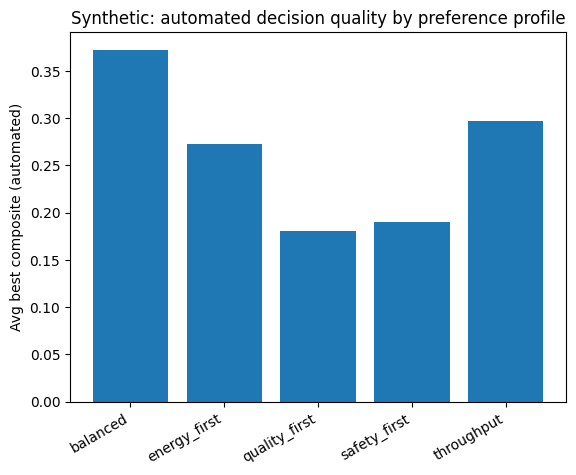

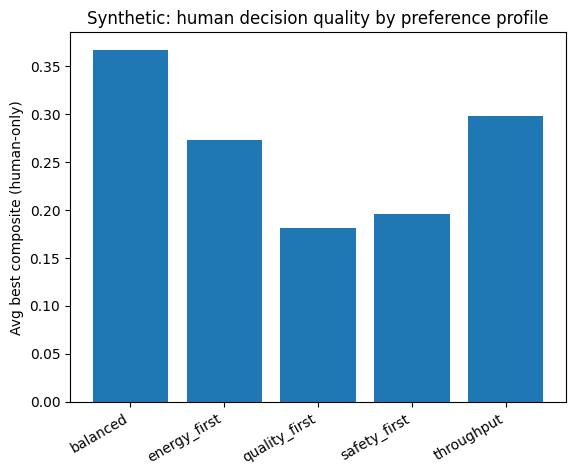

In [ ]:
# Simple plot: average best composite by profile (lower is better)
plot_df = syn_df.groupby("profile")[["best_composite_automated", "best_composite_human"]].mean().reset_index()

plt.figure()
plt.bar(plot_df["profile"], plot_df["best_composite_automated"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Avg best composite (automated)")
plt.title("Synthetic: automated decision quality by preference profile")
plt.show()

plt.figure()
plt.bar(plot_df["profile"], plot_df["best_composite_human"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Avg best composite (human-only)")
plt.title("Synthetic: human decision quality by preference profile")
plt.show()


Part C — Real-world track (AI4I 2020 via OpenML) (Section 5.3)
Cell 10 — Load AI4I 2020 dataset (OpenML)

In [ ]:
import openml
import pandas as pd

# Load AI4I 2020 dataset from OpenML
ds = openml.datasets.get_dataset(42890)

# Get full data WITHOUT relying on default target metadata
X, _, _, attribute_names = ds.get_data()

# Convert to DataFrame
df = X.copy()

print("Available columns:")
print(df.columns.tolist())

# Manually define the target column (AI4I 2020)
TARGET_COL = "Machine failure"

# Sanity check
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {df.columns.tolist()}")

# Create binary target
df["target"] = df[TARGET_COL].astype(int)

print("\nDataset shape:", df.shape)
print("\nTarget distribution:")
print(df["target"].value_counts())

df.head()


Available columns:
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

Dataset shape: (10000, 15)

Target distribution:
target
0    9661
1     339
Name: count, dtype: int64


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,target
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0


Cell 11 — Train a simple failure predictor

In [ ]:
# Basic cleaning: remove identifiers if present
drop_cols = [c for c in df.columns if c.lower() in ["udi", "product id", "product_id", "uid"]]
df2 = df.drop(columns=drop_cols, errors="ignore")

# Identify features/target
y = df2["target"]
X = df2.drop(columns=["target"])

# If target is not binary numeric, coerce
if y.dtype == "object":
    y = (y.astype(str).str.lower().isin(["1", "true", "yes", "failure"])).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if any(X_train.dtypes == "object") else StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000))
])

# If there are non-numeric columns, coerce (AI4I usually numeric/categorical-like)
X_train_num = X_train.copy()
X_test_num = X_test.copy()
for c in X_train_num.columns:
    if X_train_num[c].dtype == "object":
        X_train_num[c] = pd.factorize(X_train_num[c])[0]
        X_test_num[c] = pd.factorize(X_test_num[c])[0]

clf.fit(X_train_num, y_train)
proba = clf.predict_proba(X_test_num)[:, 1]
pred = (proba >= 0.5).astype(int)

print("AUC:", round(roc_auc_score(y_test, proba), 3))
print("Acc:", round(accuracy_score(y_test, pred), 3))


AUC: 1.0
Acc: 1.0


Cell 12 — Convert predictions into disruption events

In [ ]:
test = X_test_num.copy()
test["failure_proba"] = proba
test["y_true"] = y_test.values

# Trigger disruption when risk exceeds threshold
THRESH = 0.35
events = test[test["failure_proba"] >= THRESH].copy()

print("Triggered events:", len(events), "out of", len(test))
events[["failure_proba", "y_true"]].head()


Triggered events: 85 out of 2500


,failure_proba,y_true
8307,0.999534,1
4661,0.999339,1
327,0.999389,1
2671,0.999459,1
3814,0.999510,1


NEW CELL (insert right after Cell 12)

In [ ]:
# --- Create risk bands for richer decision diversity ---
def assign_risk_band(p: float) -> str:
    if p < 0.35:
        return "low"
    elif p < 0.70:
        return "medium"
    else:
        return "high"

test_band = test.copy()  # 'test' comes from Cell 12
test_band["risk_band"] = test_band["failure_proba"].apply(assign_risk_band)

print(test_band["risk_band"].value_counts())
test_band[["failure_proba", "risk_band", "y_true"]].head()


risk_band
low     2415
high      85
Name: count, dtype: int64


,failure_proba,risk_band,y_true
1390,0.000054,low,0
2925,0.000071,low,0
2488,0.000057,low,0
5844,0.000048,low,0
7978,0.000050,low,0


Cell 13 — Map a risk event to action impacts

This is where we connect AI4I risk → decision objectives. We keep it simple and transparent.

In [ ]:
def impacts_from_risk(failure_proba: float) -> pd.DataFrame:
    """
    Risk-aware action impacts.
    At low risk, continuity-preserving actions are favored.
    At high risk, conservative actions are favored.
    """
    r = float(np.clip(failure_proba, 0, 1))

    impacts = {
        # Continuity actions: cheap at low risk, expensive at high risk
        "bypass": {
            "delay": 6  + 40*r,
            "energy": 6  + 15*r,
            "quality": 6  + 30*r,
            "safety": 4  + 40*r,
        },
        "degraded_mode": {
            "delay": 5  + 30*r,
            "energy": 5  + 12*r,
            "quality": 5  + 25*r,
            "safety": 3  + 35*r,
        },

        # Conservative actions: expensive at low risk, cheap at high risk
        "repair_now": {
            "delay": 25 - 10*r,
            "energy": 12 -  4*r,
            "quality": 8  -  4*r,
            "safety": 6  -  3*r,
        },
        "reschedule": {
            "delay": 22 - 12*r,
            "energy": 10 -  5*r,
            "quality": 7  -  4*r,
            "safety": 5  -  3*r,
        },
    }

    return pd.DataFrame.from_dict(impacts, orient="index")


Cell 14 — Run real-world decision experiments (with optional LLM explanations)

In [ ]:
def run_ai4i_decisions_by_band(
    n_per_band: int = 25,
    profile: str = "balanced",
    use_llm: bool = True,
    random_state: int = 42
) -> pd.DataFrame:
    weights = WEIGHT_PROFILES[profile]

    rows = []
    rng_local = np.random.default_rng(random_state)

    for band in ["low", "medium", "high"]:
        band_df = test_band[test_band["risk_band"] == band].copy()
        if len(band_df) == 0:
            print(f"[WARN] No samples for band='{band}'. Consider adjusting thresholds.")
            continue

        # Sample up to n_per_band from this risk band
        sample_n = min(n_per_band, len(band_df))
        sample = band_df.sample(sample_n, random_state=random_state)

        for idx, row in sample.iterrows():
            risk = float(row["failure_proba"])
            impacts = impacts_from_risk(risk)  # existing function from Cell 13
            ranked = rank_actions(impacts, weights)

            automated_choice = ranked.loc[0, "action"]

            payload = {
                "event": {
                    "failure_proba": risk,
                    "risk_band": band,
                    "y_true": int(row.get("y_true", -1))
                },
                "weights": weights,
                "ranking_table": ranked.to_dict(orient="records"),
            }

            explanation = llm_explain_ranking(payload) if use_llm else ""

            rows.append({
                "event_id": str(idx),
                "failure_proba": risk,
                "risk_band": band,
                "y_true": int(row.get("y_true", -1)),
                "profile": profile,
                "automated_choice": automated_choice,
                "best_composite": float(ranked.loc[0, "composite"]),
                "llm_explanation": explanation
            })

    return pd.DataFrame(rows)

ai4i_df = run_ai4i_decisions_by_band(n_per_band=20, profile="balanced", use_llm=True)
ai4i_df.head()


[WARN] No samples for band='medium'. Consider adjusting thresholds.


,event_id,failure_proba,risk_band,y_true,profile,automated_choice,best_composite,llm_explanation
0,1750,0.000066,low,0,balanced,degraded_mode,0.0,The recommended action is **degraded_mode** be...
1,5463,0.000046,low,0,balanced,degraded_mode,0.0,Recommend **degraded_mode** because it has the...
2,3376,0.000065,low,0,balanced,degraded_mode,0.0,The recommended action is **degraded_mode** be...
3,7630,0.000046,low,0,balanced,degraded_mode,0.0,Recommend **degraded_mode** because it has the...
4,7270,0.000046,low,0,balanced,degraded_mode,0.0,The recommended action is **degraded_mode** be...


NEW CELL (right after the new Cell 14)

In [ ]:
# --- Summaries for the paper ---
choice_by_band = (
    ai4i_df.groupby(["risk_band", "automated_choice"])
    .size()
    .reset_index(name="count")
    .sort_values(["risk_band", "count"], ascending=[True, False])
)

risk_stats_by_band = (
    ai4i_df.groupby("risk_band")["failure_proba"]
    .agg(["count", "mean", "median", "min", "max"])
    .reset_index()
)

print("Choice distribution by risk band:")
print(choice_by_band)

print("\nRisk stats by band:")
print(risk_stats_by_band)


Choice distribution by risk band:
  risk_band automated_choice  count
0      high       reschedule     20
1       low    degraded_mode     20

Risk stats by band:
  risk_band  count      mean    median       min       max
0      high     20  0.994801  0.999416  0.948569  0.999992
1       low     20  0.000058  0.000055  0.000046  0.000088


4) Add one plot: choice distribution by risk band
NEW CELL

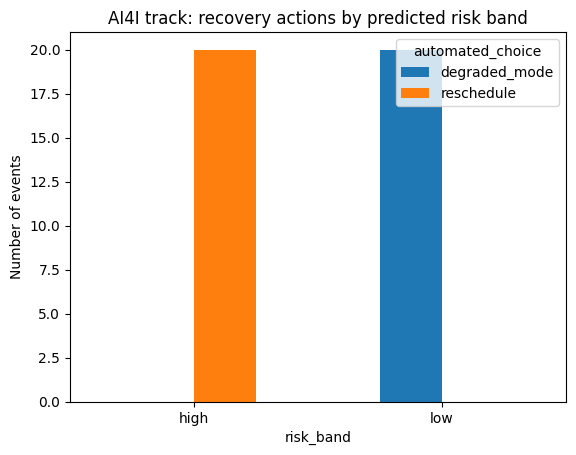

In [ ]:
# Pivot for plot
pivot = choice_by_band.pivot(index="risk_band", columns="automated_choice", values="count").fillna(0)

pivot.plot(kind="bar")
plt.ylabel("Number of events")
plt.title("AI4I track: recovery actions by predicted risk band")
plt.xticks(rotation=0)
plt.show()


Cell 15 — Produce results tables for Section 6

In [ ]:
# How often each action is selected (AI4I track)
choice_counts = ai4i_df["automated_choice"].value_counts().rename_axis("action").reset_index(name="count")
choice_counts


,action,count
0,degraded_mode,20
1,reschedule,20


In [ ]:
# Distribution of failure probabilities per chosen action
stats = ai4i_df.groupby("automated_choice")["failure_proba"].agg(["count","mean","median","min","max"]).reset_index()
stats


,automated_choice,count,mean,median,min,max
0,degraded_mode,20,0.000058,0.000055,0.000046,0.000088
1,reschedule,20,0.994801,0.999416,0.948569,0.999992


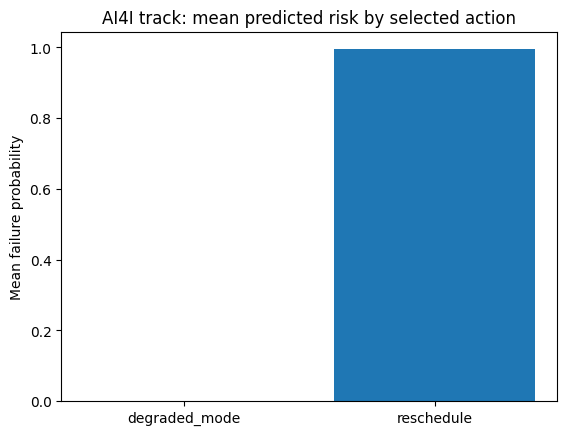

In [ ]:
# Plot: mean risk vs action
plt.figure()
plt.bar(stats["automated_choice"], stats["mean"])
plt.ylabel("Mean failure probability")
plt.title("AI4I track: mean predicted risk by selected action")
plt.show()


Cell 16 — Simple “explanation quality” proxy metrics

We can quantify some properties of LLM text (not perfect, but useful as evidence).

In [ ]:
def explanation_metrics(text: str) -> dict:
    t = text or ""
    return {
        "chars": len(t),
        "words": len(t.split()),
        "mentions_delay": int("delay" in t.lower()),
        "mentions_energy": int("energy" in t.lower()),
        "mentions_quality": int("quality" in t.lower()),
        "mentions_safety": int("safety" in t.lower()),
    }

exp_metrics = pd.DataFrame([explanation_metrics(t) for t in ai4i_df["llm_explanation"]])
exp_summary = exp_metrics.mean(numeric_only=True).to_frame("avg").T
exp_summary


,chars,words,mentions_delay,mentions_energy,mentions_quality,mentions_safety
avg,1357.3,185.875,1.0,1.0,1.0,1.0


Cell 17 — Export tables for the paper

In [ ]:
os.makedirs("outputs", exist_ok=True)

# Save AI4I enriched outputs
ai4i_df.to_csv("outputs/ai4i_events_with_explanations.csv", index=False)
choice_by_band.to_csv("outputs/ai4i_choice_by_risk_band.csv", index=False)
risk_stats_by_band.to_csv("outputs/ai4i_risk_stats_by_band.csv", index=False)

print("Saved:")
print("- outputs/ai4i_events_with_explanations.csv")
print("- outputs/ai4i_choice_by_risk_band.csv")
print("- outputs/ai4i_risk_stats_by_band.csv")


Saved:
- outputs/ai4i_events_with_explanations.csv
- outputs/ai4i_choice_by_risk_band.csv
- outputs/ai4i_risk_stats_by_band.csv
